Dataloaders, training models, and evaluation

In [ ]:
# Mount Drive 
from google.colab import drive

drive.mount('/content/gdrive')


#Change to the correct directory
import os
os.chdir('/content/gdrive/My Drive/junior/442')

!ls
!pwd


#Make imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import os
import numpy as np
import PIL
from PIL import Image
import cv2 as cv
from cv2 import imread
import time
import copy


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


In [ ]:
# Double check done the files are correctly mounted


#should all be 250
!ls -l ./png | grep "^d" | wc -l
!ls -l ./png224 | grep "^d" | wc -l
!ls -l ./png224output/train | grep "^d" | wc -l
!ls -l ./png224output/test | grep "^d" | wc -l
!ls -l ./png224output/val | grep "^d" | wc -l

# 48 16 16
!ls -l ./png224output/train/airplane | egrep -c '^-'
!ls -l ./png224output/test/airplane | egrep -c '^-'
!ls -l ./png224output/val/airplane | egrep -c '^-'

# all 80
!ls -l ./png224/airplane | egrep -c '^-'
!ls -l ./png224/zebra | egrep -c '^-'
!ls -l ./png/zebra | egrep -c '^-'
!ls -l ./png/airplane | egrep -c '^-'

#Dataloaders#

In [3]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    composed_transform =  transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    data_dir = "png224output/"
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [4]:
batch_size = 16
input_size = 224
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 12,000/4000/4000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 12000
# of validation samples 4000
# of test samples 4000


In [48]:
# from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Will load a given pretrained model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    elif model_name == "googlenet":
        model_ft =  models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "shufflenet":
        model_ft = models.shufflenet_v2_x1_0(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet":
        model_ft = models.mobilenet_v2(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnext":
        model_ft = models.resnext50_32x4d(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mnasnet":
        model_ft = models.mnasnet1_0(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        print(model_ft.classifier)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "wideresnet":
        model_ft = models.wide_resnet50_2(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#Training#

In [19]:
# Train a input model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [64]:
def train_given_model(model_name, pretrained=True):
  """ Driver for training a model

    Args:
        model_name: str, "densenet", "resnet", "alexnet", "vgg", "squeezenet"

    Returns:
        models saved to models/224stateDict_<model_name>.pth
  """
  num_classes = 250
  # Flag for feature extracting. When False, we finetune the whole model,
  #   when True we only update the reshaped layer params
  feature_extract = False
  # Initialize the model for this run
  model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

  # Print the model we just instantiated
  print(model_ft)


  # Send the model to GPU
  model_ft = model_ft.to(device)

  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


  # Setup the loss fxn
  criterion = nn.CrossEntropyLoss()
  num_epochs = 20

  # Train model
  model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

  addition= "20_pretrained" if pretrained else "untrained"
  # Save model
  #torch.save(model_ft.state_dict(), 'models/{}_224stateDict_{}.pth'.format(addition, model_name))
  torch.save(model_ft, 'models/{}_224Model_{}.pth'.format(addition, model_name))
  torch.save(val_acc_history, 'models/{}_224val_acc_Hist_{}.pth'.format(addition, model_name))
  torch.save(val_loss_history, 'models/{}_224val_loss_Hist_{}.pth'.format(addition, model_name))
  torch.save(train_acc_history, 'models/{}_224train_acc_Hist_{}.pth'.format(addition, model_name))
  torch.save(train_loss_history, 'models/{}_224train_loss_Hist_{}.pth'.format(addition, model_name))



In [74]:
#!mkdir models
#Train all the models
model_types_to_train = ["googlenet", "alexnet", "vgg", "squeezenet", "densenet", "resnet", "mobilenet", "shufflenet", "resnext", "mnasnet", "wideresnet", "googlenet"]

In [ ]:

for model in model_types_to_train:
  train_given_model(model)

#training from scratch would take too long
#for model in model_types_to_train:
#  train_given_model(model, pretrained=False)

#Evaluation#

In [67]:
def test(model, dataloader, topk):
    model.eval()
    cor = 0
    accPerClass = []
    for inputs, labels in dataloader:
      labels = labels.cuda()
      inputs = inputs.cuda()
      output = model(inputs)
      _, preds = torch.topk(output, topk, 1)
      preds = preds.cuda()
      numCorrectThisOne = 0
      for idx in range(len(preds)):
        if (labels[idx] in preds[idx]):
          numCorrectThisOne += 1
          cor += 1
      accPerClass.append(numCorrectThisOne/16)
    #print('accuracy of {}%'.format(cor/4000))
    return accPerClass, cor/4000


In [ ]:
# Evaluate models top 1
accuracies1 = []
accuracies5 = []

accuracies15_1 = []
accuracies15_5 = []
for model in model_types_to_train:
  loaded_model = torch.load('models/20_pretrained_224Model_{}.pth'.format(model))
  loaded_model.eval()
  accuracies, acc1 = test(loaded_model, dataloaders_dict['test'], 1)
  accuracies, acc2 = test(loaded_model, dataloaders_dict['test'], 5)
  print(str(model) + " top1 - " + str(acc1) + "  top5 - " + str(acc2))

  #compare to 15 epoch
  #loaded_model = torch.load('models/15_pretrained_224Model_{}.pth'.format(model))
  #loaded_model.eval()
  #print("15 epoch:")
  #accuracies, acc1 = test(loaded_model, dataloaders_dict['test'], 1)
  #accuracies, acc2 = test(loaded_model, dataloaders_dict['test'], 5)
  #print("top1 - " + str(acc1) + "  top5 - " + str(acc2))




In [ ]:

#calculate vanilla accuracites
for model in model_types_to_train:

    num_classes = 250
    # Flag for feature extracting. When False, we finetune the whole model,
    #   when True we only update the reshaped layer params
    feature_extract = True
    # Initialize the model for this run
    model_ft, input_size = initialize_model(model, num_classes, feature_extract, use_pretrained=True)
    model_ft.eval()
    print(model)
    model_ft = model_ft.cuda()
    accuracies, acc1 = test(model_ft, dataloaders_dict['test'], 1)
    accuracies, acc2 = test(model_ft, dataloaders_dict['test'], 5)
    print("top1 - " + str(acc1) + "  top5 - " + str(acc2))


In [ ]:
20 epoch models
alexnet     top1 - 0.659    top5 - 0.8805
vgg         top1 - 0.72425  top5 - 0.909
squeezenet  top1 - 0.6595   top5 - 0.87925
densenet    top1 - 0.75175  top5 - 0.93375
resnet      top1 - 0.735    top5 - 0.923
mobilenet   top1 - 0.729    top5 - 0.91475
shufflenet  top1 - 0.168    top5 - 0.392
resnext     top1 - 0.7555   top5 - 0.94
mnasnet     top1 - 0.7205   top5 - 0.92075
wideresnet  top1 - 0.76525  top5 - 0.93525
googlenet   top1 - 0.7175   top5 - 0.91875



15 epoch models
alexnet     top1 - 0.66125  top5 - 0.874
vgg         top1 - 0.7215   top5 - 0.909
squeezenet  top1 - 0.6585   top5 - 0.87
densenet    top1 - 0.75325  top5 - 0.93
resnet      top1 - 0.72875  top5 - 0.92075
googlenet   top1 - 0.6775   top5 - 0.87825


vanilla models
alexnet        top1 - 0.005    top5 - 0.02375
vgg            top1 - 0.00425  top5 - 0.022
squeezenet     top1 - 0.0055   top5 - 0.026
densenet       top1 - 0.0025   top5 - 0.02325
resnet         top1 - 0.00425  top5 - 0.02275
googlenet      top1 - 0.00025  top5 - 0.00075

In [ ]:
# 241=violin, 95=guitar
# Check which models predict what for test set
def check_for(model_in, classIdx):
  ##print tensor of class idx
  classIdx = 241
  i = 0
  model_in.eval()
  for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.cuda()
    if (classIdx != i):
      i += 1
      continue
    output = model_in(inputs)
    _, preds = torch.max(output, 1)
    print(preds)
    break

for model in model_types_to_train:
  loaded_model = torch.load('models/pretrained_224Model_{}.pth'.format(model))
  loaded_model.eval()
  print(model)
  check_for(loaded_model, 241)

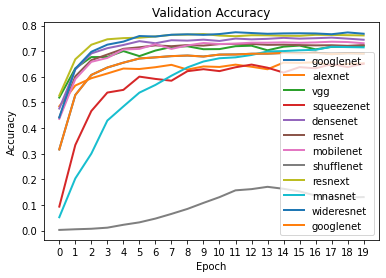

In [78]:
#test plot
epochs = 20
x = np.arange(epochs)


import matplotlib.pyplot as plt
model_types_to_train = ["googlenet", "alexnet", "vgg", "squeezenet", "densenet", "resnet", "mobilenet", "shufflenet", "resnext", "mnasnet", "wideresnet", "googlenet"]
plt.figure()
for model in model_types_to_train:
  try:
    hist = torch.load('models/pretrained_224val_acc_Hist_{}.pth'.format(model))
  except:
    hist = torch.load('models/20_pretrained_224val_acc_Hist_{}.pth'.format(model))
  plt.plot(x, hist, label='%s' % model, linewidth=2)



plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.savefig("ValidationAccuracy.png")
plt.legend()
plt.show()
